In [1]:
# Pipeline 2 description
# Fit a beta distribution to all the tissue columns w/o the nan values in the training set.
# Use the beta distributions conditioned on the location to fill the NaN values.
# Once you have finished filling in the NaNs, your training set will be complete
# To fill in the values in the test set, take the test vector's values, locations and find the
# top x distributions that the vector is most likely to come from.
# Use these top x as the training set for a regressor that will be used to predict the missing values in the training
# set.

In [1]:
# load imports
import math
import numpy as np 
from IPython.display import Image  
import pandas
import os
from scipy.stats import beta
# Enter your directory here
os.chdir('/Users/abkhanna/Documents/workspace/Princeton/cos424/a2/methylation_imputation-master')

In [2]:
# Load the data
train_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_train.bed', sep='\t', header=None)
sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)

In [3]:
# fit the distributions
# first trial with just a single tissue
tissue_sample = train_bed[4]
tissue_sample_list = tissue_sample
# remove NaNs
tissue_sample_no_nans = [x for x in tissue_sample_list if ~np.isnan(x)]
a, b, loc, scale = beta.fit(tissue_sample_no_nans)

In [7]:
# build the beta for the test vector
# use the beta to generate the values for the missing values.
beta_gen = np.random.beta
tissue_sample_nan_rep = [x if ~np.isnan(x) else beta_gen(a, b) for x in tissue_sample_list]

In [4]:
# now time to do it with the entire set!
def fill_col(col):
    col_sample_list = col
#     col_sample_no_nans = [x for x in col_sample_list if ~np.isnan(x)]
#     a, b, loc, scale = beta.fit(col_sample_no_nans)
#     beta_gen = np.random.beta
#     col_sample_nan_rep = [x if ~np.isnan(x) else beta_gen(a, b) for x in col_sample_list]
    col_sample_nan_rep = [x if ~np.isnan(x) else 0.5 for x in col_sample_list]
    return col_sample_nan_rep

table1 = train_bed[list(range(4,37))]
table2 = []
for i in range(4, 37):
    table2.append(fill_col(table1[i]))
table2 = pandas.DataFrame(table2).transpose()


In [5]:
# Now create a list of (a,b) pairs so you can figure out which distribution is the most likely 
# for your similarity metric
# table2 has all the NaN values filled in in the training set.
ab_tuples = []
def get_ab(col):
    a, b, loc, scale = beta.fit(col)
    return a,b

for i in range(0,32):
    print i
    ab_tuples.append(get_ab(table2[i]))

print len(ab_tuples)

0
1
2
3
4


/Users/abkhanna/Documents/workspace/Princeton/cos424/a2/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [7]:
# once we have the list of ab tuples, we can use them to calculate the probability
# that the test vector came from any one of these distributions
test_vector_nans = sample_p_bed[4] # 4th column has the data, others are informatory
test_vector_no_nans = [x for x in test_vector_nans if ~np.isnan(x)]
similarity_scores = []
i = 0
for a, b in ab_tuples:
    print i
    running_product = 0
    for meth in test_vector_no_nans:
        assert (0 < meth < 1)
        probability = beta.logpdf(meth, a, b)
        running_product = running_product + probability
    similarity_scores.append((running_product, i))
    i = i + 1

# sort the scores by the first tuple value
sorted_similarity = sorted(similarity_scores, key=lambda tup: tup[0])
print len(sorted_similarity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [31]:
# take the top x number of these vectors, and use their values to create a regression.
top_x = 3

y1 = table2[sorted_similarity[-1][1]].as_matrix().tolist()
y2 = table2[sorted_similarity[-2][1]].as_matrix().tolist()
y3 = table2[sorted_similarity[-3][1]].as_matrix().tolist()
# print len(y1)
# print len(y2)
# print len(y3)
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
xs = train_bed[1].as_matrix().tolist()
X = xs
print "X Len: {0}".format(len(X))
print "xs len: {0}".format(len(xs))
Y = y1
print "Y len: {0}".format(len(Y))
X = np.array(X).reshape(-1,1)
X_full = np.concatenate((X[0:0+window_size], X[0:0+window_size], X[0:0+window_size]))
print "X shape: {0}".format(X_full.shape)
Y = np.array(Y)
print "Y shape: {0}".format(Y.shape)
print "Done!"


X Len: 379551
xs len: 379551
Y len: 379551
X shape: (30, 1)
Y shape: (379551,)
Done!


In [28]:
# define the window_size
window_size = 10

In [32]:
# split the elements of X and Y into chunks of 5,000 to prevent fitting time complexity issues
# len of x = len of y
X_partials_array = []
Y_partials_array = []
for i in range(0,len(X), window_size):
    X_full = np.concatenate((X[i:i+window_size], X[i:i+window_size], X[i:i+window_size]))
    Y_full = np.concatenate((y1[i:i+window_size], y2[i:i+window_size], y3[i:i+window_size]))
    X_partials_array.append(X_full)
    Y_partials_array.append(Y_full)


In [33]:
# http://datascience.stackexchange.com/questions/989/
# ... svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
# suggests subsampling the data set rather than using the entirety of it.
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

svrs = [] # array of svr kernels split across every 5000 rows
for i in range(0, len(X_partials_array)):
    print i
#     svr_rbf = SVR(kernel='poly', C=1e3, gamma=0.01, cache_size=7000)
    svr_rbf = RandomForestRegressor(random_state=0, max_depth=100)
    svr_rbf.fit(X_partials_array[i], Y_partials_array[i])
    svrs.append(svr_rbf)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
# from these svrs, predict the missing values in the test vector!
test_tissue = sample_p_bed[4]
nan_vector = sample_p_bed[5]
test_loc_vector = sample_p_bed[1]
filled_test_tissue = []
predict_count = 0
orc = 0

def predict(i):
    svr_bucket = int(i / window_size) # window_size is defined a few cells above
    svr_regressor = svrs[svr_bucket]
    y_predict = svr_regressor.predict(test_loc_vector[i])
    if y_predict > 1:
        return [0.45], 1
    if y_predict < -1:
        return [0.45], 1
    return y_predict, 0

for i in range(len(nan_vector)):
    if i % 10000 == 0:
        print i
    if nan_vector[i] == 0 or np.isnan(test_tissue[i]):
        # fill it in!!!
        predict_count = predict_count + 1
        y_predict, n_orc = predict(i)
        orc = orc + n_orc
        assert 0 < y_predict[0] < 1
        filled_test_tissue.append(y_predict[0])
    elif nan_vector[i] == 1:
        # value is valid! just use it
        y_actual = test_tissue[i]
        assert 0 < y_actual < 1
        filled_test_tissue.append(y_actual)
    else:
        raise ValueError('Invalid state in nan_vector')

print "Filled_test_tissue: {0}".format(len(filled_test_tissue))
print "Test Tissue: {0}".format(len(test_tissue))
print "Predict Count: {0}".format(predict_count)
print "Over range Count: {0}".format(orc)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
Filled_test_tissue: 379551
Test Tissue: 379551
Predict Count: 372028
Over range Count: 0


In [26]:
# http://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

375934
375934
[[ 1.          0.58135541]
 [ 0.58135541  1.        ]]
0.178444188905


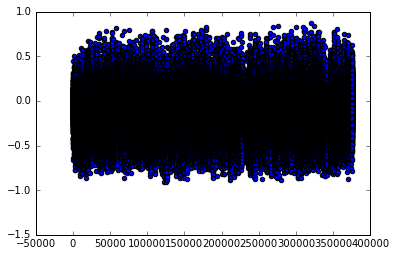

In [35]:
# now we need to do the comparisons to check how well our imputation worked!
# to test / grade our efforts, we will use r^2 correlation between this vector + the actual "ground truth" vector
# We will also use RMSE value, and a graph of the residuals to understand where the error is most concentrated.
# Due to a lack of time, we will not be able to iterate on this design; however, hopefully this will at the very
# least provide good insight into how we could progress further if we wanted to.
%matplotlib inline
import matplotlib.pyplot as plt

full_values_vector = sample_f_bed[4]
full_values = [full_values_vector[x] for x in range(len(filled_test_tissue)) if ~np.isnan(full_values_vector[x])]
filled_test = [filled_test_tissue[x] for x in range(len(filled_test_tissue)) if ~np.isnan(full_values_vector[x])]
diff_test = [filled_test[x] - full_values[x] for x in range(len(filled_test))]
print len(full_values)
print len(filled_test)
print(np.corrcoef(filled_test, full_values))
print(rmse(np.array(filled_test), np.array(full_values)))
plt.figure(1)
plt.scatter(np.array(full_values), np.array(filled_test))
plt.figure(2)
plt.scatter([i for i in range(len(filled_test))], diff_test)
plt.show()

In [29]:
for x in filled_test:
#     print x
    assert -1 <= x <= 1, x